In [43]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt

review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)
feature_dim = 1000
vectorizer = CountVectorizer(max_features=feature_dim, min_df=6, max_df=0.5, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cieli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cieli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [44]:
X_train, X_test = np.transpose(X_train), np.transpose(X_test)
y_train, y_test = y_train.reshape((1,-1)), y_test.reshape((1,-1))

In [45]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def dev_sigmoid(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [46]:
class Affine:
    def __init__(self, in_dim:int, dim:int, reg:float):
        self.W = np.matrix(np.random.normal(0, 1.0, (dim, in_dim)))
        self.reg = reg
    
    def forward(self, x):
        self.x = x
        self.out = np.matmul(self.W, self.x)
        self.sig_out = sigmoid(self.out)
        
        return self.sig_out

    def forward_test(self, x):
        return sigmoid(np.matmul(self.W, x))

    def backward(self, dout, lr:float, par_num):
        self.dW = np.matmul(dout, np.transpose(self.x)) + (self.reg / float(par_num)) * self.W
        self.W -= lr * self.dW
        
    def l2_weights(self):
        squared_sum = np.sum(np.power(self.W, 2))
        return squared_sum

    def num_weights(self):
        num = self.W.shape[0] * self.W.shape[1]
        return num

In [47]:
class NeuralNetwork:
    def __init__(self, reg:float):
        self.layers = [
            Affine(feature_dim, 600, reg),
            Affine(600, 200, reg),
            Affine(200, 1, reg)
        ]
        self.reg = reg
        self.num_weights = 0

        for layer in self.layers:
            self.num_weights += layer.num_weights()

    def loss(self, label):
        self.loss_mat = np.multiply(-label, np.log(self.out)) - np.multiply((1.0 - label), np.log(1.0 - self.out))
        self.reg_term = 0.0
        for layer in self.layers:
            self.reg_term += layer.l2_weights()
        self.reg_term = (self.reg / float( 2 * self.num_weights)) * self.reg_term

        return (1.0 / label.shape[1]) * np.sum(self.loss_mat) + self.reg_term

    def accuracy(self, label):
        self.prediction = np.where(self.out > 0.5, 1.0, 0.0)
        correct, miss = 0, 0
        for i in range(label.shape[1]):
            if self.prediction[0, i] == label[0, i]:
                correct = correct + 1
            else:
                miss = miss + 1
        
        return float(correct) / float(correct + miss)

    def test(self, X, y):
        out = X
        for layer in self.layers:
            out = layer.forward_test(out)

        loss_mat = np.multiply(-y, np.log(out)) - np.multiply((1.0-y), np.log(1.0 - out))
        reg_term = 0.0
        for layer in self.layers:
            reg_term += layer.l2_weights()
        reg_term = (self.reg / float(2 * self.num_weights)) * reg_term

        loss = (1.0 / y.shape[1]) * np.sum(loss_mat) + reg_term
        
        self.test_prediction = np.where(out > 0.5, 1.0, 0.0)
        correct, miss = 0, 0
        for i in range(y.shape[1]):
            if self.test_prediction[0, i] == y[0, i]:
                correct = correct + 1
            else:
                miss = miss + 1
        acc = float(correct) / float(correct + miss)
        
        return loss, acc

    def forward(self, x):
        self.out = x
        for layer in self.layers:
            self.out = layer.forward(self.out)

    def backward(self, label, lr:float):
        dJ = np.divide(1.0 - label, 1.0 - self.out) - np.divide(label, self.out)
        ds = dev_sigmoid(self.layers[-1].out)
        gradient = np.multiply(dJ, ds)

        for i, layer in reversed(list(enumerate(self.layers))):
            layer.backward(gradient, lr, self.num_weights)
            if i == 0:
                break
            gradient = np.matmul(np.transpose(layer.W), gradient)
            gradient = np.multiply(gradient, dev_sigmoid(self.layers[i-1].out)) 

In [48]:
iterations = 5000

train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

regularization = 1.1
learning_rate = 0.00001

network = NeuralNetwork(regularization)

for it in range(iterations):
    network.forward(X_train)
    network.backward(y_train, learning_rate)
    
    train_losses.append(network.loss(y_train))
    train_accuracies.append(network.accuracy(y_train))

    test_loss, test_acc = network.test(X_test, y_test)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

iter_x = list(range(iterations))

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def plot_quantitatives():
    global y_train
    global y_test
    global network
    y_train = np.asarray(y_train)[0]
    y_test = np.asarray(y_test)[0]

    y_pred_train = np.asarray(network.prediction)[0]
    y_pred_test = np.asarray(network.test_prediction)[0]

    print(confusion_matrix(y_train,y_pred_train))
    print(classification_report(y_train,y_pred_train))
    print(accuracy_score(y_train, y_pred_train))

    print(confusion_matrix(y_test,y_pred_test))
    print(classification_report(y_test,y_pred_test))
    print(accuracy_score(y_test, y_pred_test))

## 1. Plot the loss curve

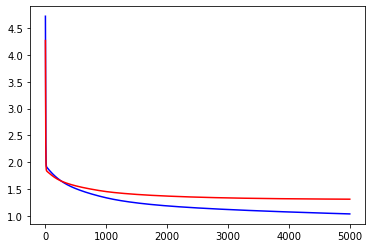

In [49]:

plt.plot(iter_x, train_losses, color='blue')
plt.plot(iter_x, test_losses, color='red')
plt.show()

## 2. plot the accuracy curve

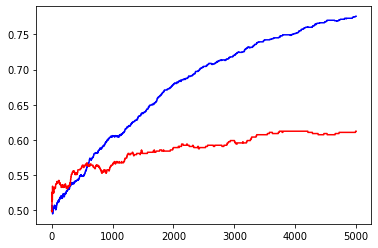

In [50]:
plt.plot(iter_x, train_accuracies, color='blue')
plt.plot(iter_x, test_accuracies, color='red')
plt.show()

In [52]:
plot_quantitatives()

[[549 150]
 [164 538]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       699
           1       0.78      0.77      0.77       702

    accuracy                           0.78      1401
   macro avg       0.78      0.78      0.78      1401
weighted avg       0.78      0.78      0.78      1401

0.7758743754461099
[[177 125]
 [108 191]]
              precision    recall  f1-score   support

           0       0.62      0.59      0.60       302
           1       0.60      0.64      0.62       299

    accuracy                           0.61       601
   macro avg       0.61      0.61      0.61       601
weighted avg       0.61      0.61      0.61       601

0.6123128119800333
